In [21]:
%pip install tqdm


import pandas as pd
import os
import pickle
from functools import reduce
from tqdm import tqdm
import matplotlib.pyplot as plt


Note: you may need to restart the kernel to use updated packages.


In [22]:
%ls

ECO/  ECO_Parser.ipynb


In [23]:

# watts to kWh conversion, where data_frequency is the fraction of an hour if we have 7 seconds data, then data_frequency = 7/3600
def watts2kwh(df: pd.DataFrame,data_frequency):
    df = df/1000 * data_frequency 
    return df


def calculate_loadprofiles(df):
    # resample to daily and hourly
    hourly = df.resample('H').sum()
    daily = df.resample('D').sum()


        
    # daily load profile
    loadprofile_daily = hourly.groupby(hourly.index.hour).mean()

    # weekly load profile
    loadprofile_weekly = daily.groupby(daily.index.dayofweek).mean()

    # monthly load profile
    loadprofile_monthly = daily.groupby(daily.index.day).mean()

    # save to dictioanry
    loadprofiles = {
        "daily": loadprofile_daily.values,
        "weekly": loadprofile_weekly.values,
        "monthly": loadprofile_monthly.values
    }
    return loadprofiles

# takes path to SM folder and returns loadprofiles for total energy consumption
def total_loadprofile(file_path_SM : str):
    total_df = pd.DataFrame()

    for f in os.listdir(file_path_SM):
        if f.endswith(".csv"):
            df = pd.read_csv(os.path.join(file_path_SM, f), header=None)
            df.drop(df.columns[1:], axis=1, inplace=True)
            df.columns = ["Total"]
            date_index = pd.date_range(start=f.split(".")[0], periods=len(df), freq='S')
            df.set_index(date_index, inplace=True)

            # ignore days with missing data
            if not (df == -1).any().any():
                total_df = pd.concat([total_df, df], axis=0)

    total_df = watts2kwh(total_df, 1/3600)

    return calculate_loadprofiles(total_df)

def device_loadprofiles(file_path : str,device_mapping : dict):
    # dict to store device load profiles
    device_lps = {}
    # read device data
    for device in tqdm(os.listdir(file_path)):
        path = file_path +"/"+ device
        device_df = pd.DataFrame()
        # get device name from map
        device_name = device_mapping[int(device)]
        for f in os.listdir(path):
            if f.endswith(".csv"):
                df = pd.read_csv(path+"/"+f, header=None)
                if len(df) != 86400:
                    print(device_name, f, len(df))
                date_index = pd.date_range(start=f.split(".")[0], periods=len(df), freq="1S")
                df["date"] = date_index
                df = df.set_index("date")
                
                df[df==-1] = 0  
                # if not (df == -1).any().any():
                    # df.rename(columns={0: device_name}, inplace=True)
                    # device_df = pd.concat([device_df, df], axis=0)
                df.rename(columns={0: device_name}, inplace=True)
                device_df = pd.concat([device_df, df], axis=0)
        
        device_df.sort_index(inplace=True)
        device_df = watts2kwh(device_df, 1/3600)

        device_lps[device_name] = calculate_loadprofiles(device_df)

    return device_lps


# return a dictionary of nubmer to device name mapping for given house 
def get_device_map(house: str):

    # number to device name mapping
    device_map_house1 = {
        1: "Fridge",
        2: "Dryer",
        3: "Coffee machine",
        4: "Kettle",
        5: "Washing machine",
        6: "PC",
        7: "Freezer",
    }

    device_map_house2 = {
        1: "Tablet",
        2: "Dishwasher",
        3: "Air exhaust",
        4: "Fridge",
        5: "Entertainment",
        6: "Freezer",
        7: "Kettle",
        8: "Lamp",
        9: "Laptops",
        10: "Stove",
        11: "TV",
        12: "Stereo",
    }

    device_map_house3 = {

        1: "Tablet",
        2: "Freezer",
        3: "Coffee machine",
        4: "PC",
        5: "Fridge",
        6: "Kettle",
        7: "Entertainment",
    }

    device_map_house4 = {
        1: "Fridge",
        2: "Kitchen appliances",
        3: "Lamp",
        4: "Stereo",
        5: "Freezer",
        6: "Tablet",
        7: "Entertainment",
        8: "Microwave",
    }

    device_map_house5 = {
        1: "Tablet",
        2: "Coffee machine",
        3: "Fountain",
        4: "Microwave",
        5: "Fridge",
        6: "Entertainment",
        7: "PC",
        8: "Kettle",
    }

    device_map_house6 = {
        1: "Lamp",
        2: "Laptop",
        3: "Router",
        4: "Coffee machine",
        5: "Entertainment",
        6: "Fridge",
        7: "Kettle",
    }

    if house == "HOUSE1":
        return device_map_house1
    elif house == "HOUSE2":
        return device_map_house2
    elif house == "HOUSE3":
        return device_map_house3
    elif house == "HOUSE4":
        return device_map_house4
    elif house == "HOUSE5":
        return device_map_house5
    elif house == "HOUSE6":
        return device_map_house6
    else:
        print("Invalid house name")
        return None
        



In [24]:


file_path_devices = "../../data/ECO/HOUSE1/PLUGS"
file_path_SM = "../../data/ECO/HOUSE1/SM"



# path to ECO data local
# path_eco = "../../data/ECO"

# path to ECO data on server
path_eco = "./ECO/"

houses_loadprofiles = {}

for house in tqdm(os.listdir(path_eco)):
    mapping = get_device_map(house)

    device_lp = device_loadprofiles(path_eco+"/"+house+"/PLUGS", mapping)
    total_lp = total_loadprofile(path_eco+"/"+house+"/SM")

    houses_loadprofiles[house] = { "devices": device_lp, "total": total_lp}




    


  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [06:19<00:00, 63.19s/it]


In [30]:
# save houses_loadprofiles to pickle file
with open("./ECO/ECO_houses_loadprofiles.pkl", "wb") as f:
    pickle.dump(houses_loadprofiles, f)
    

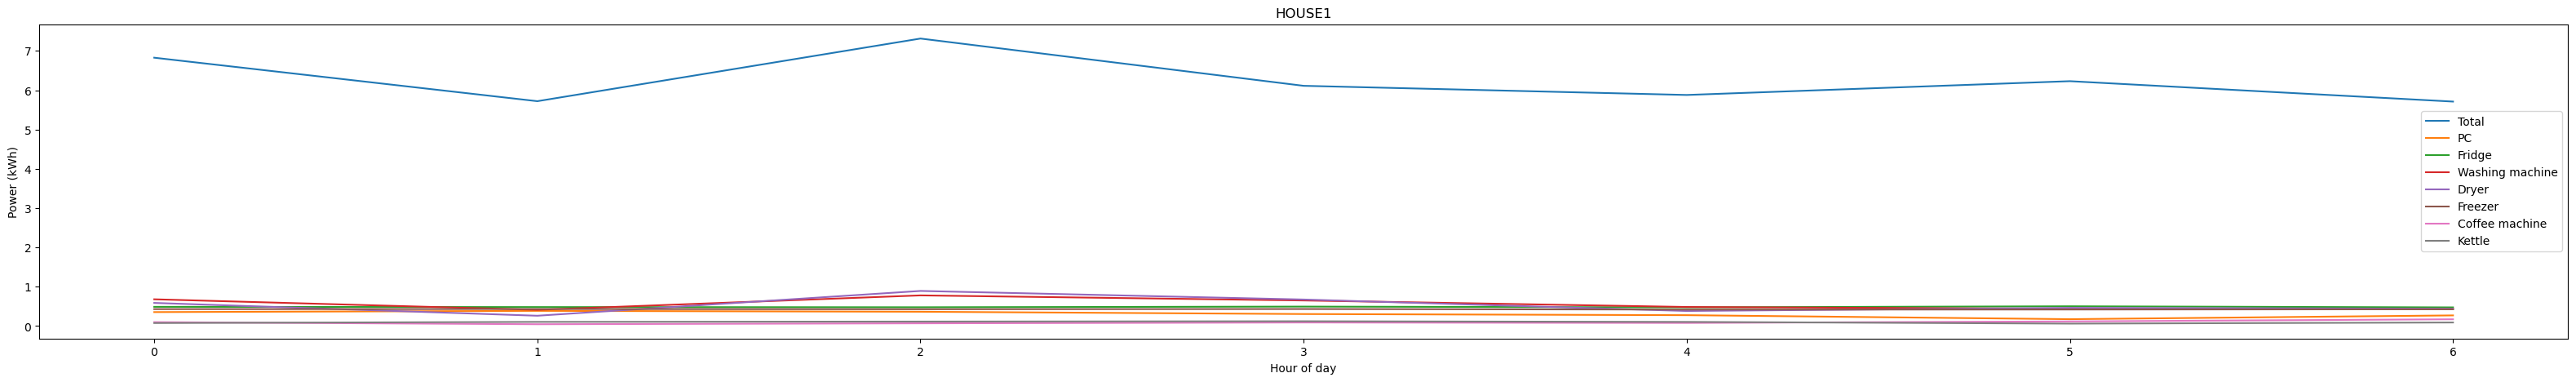

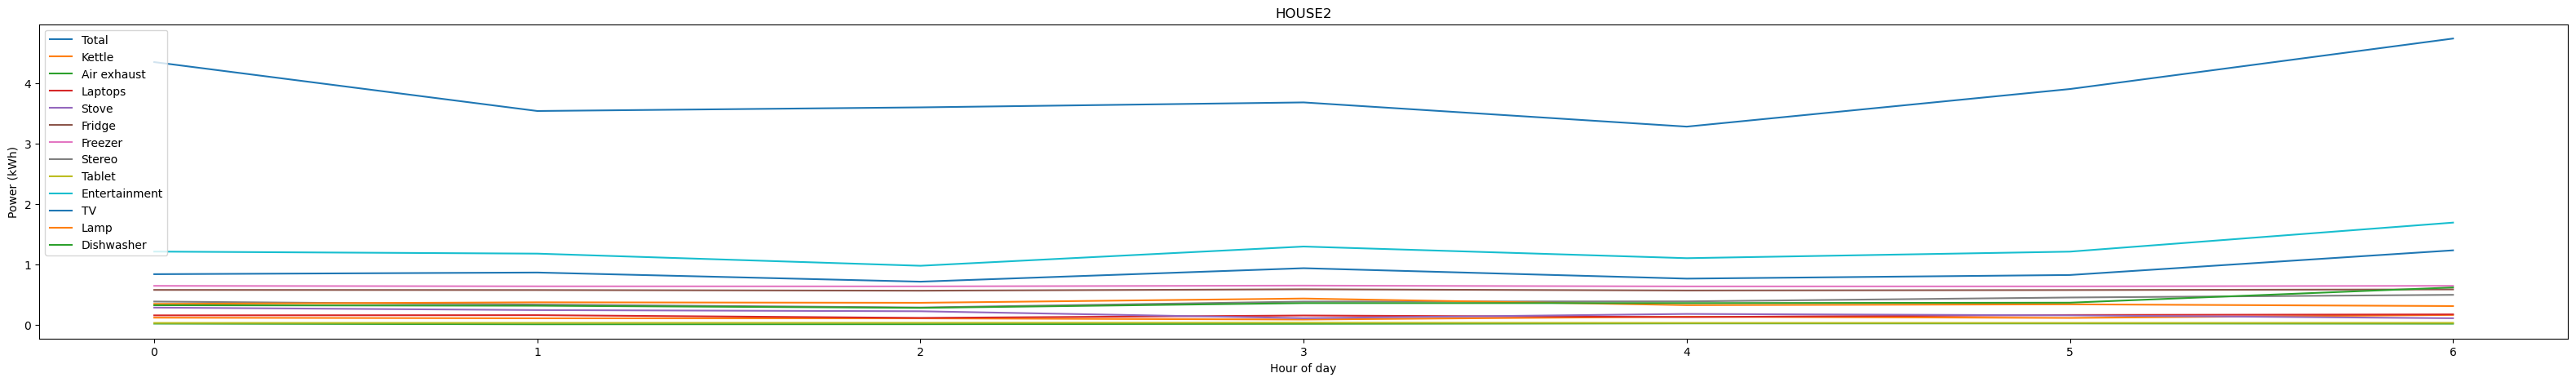

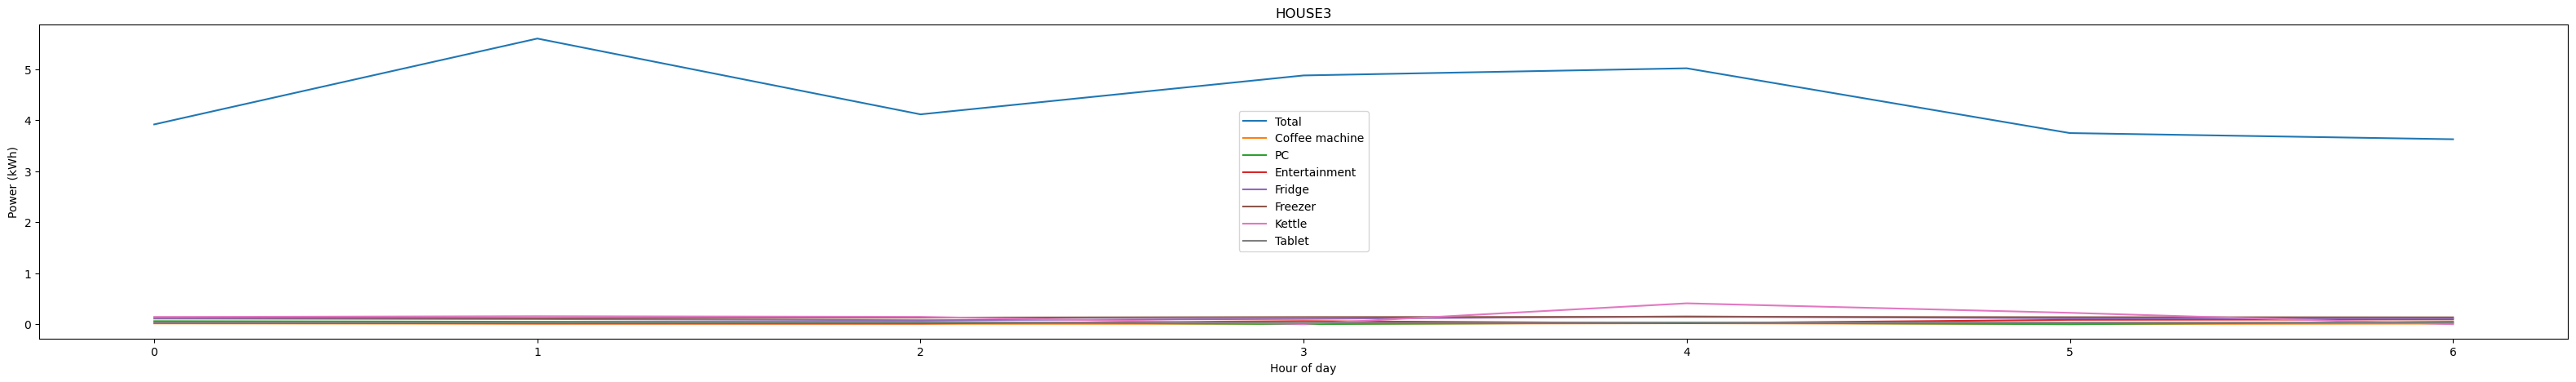

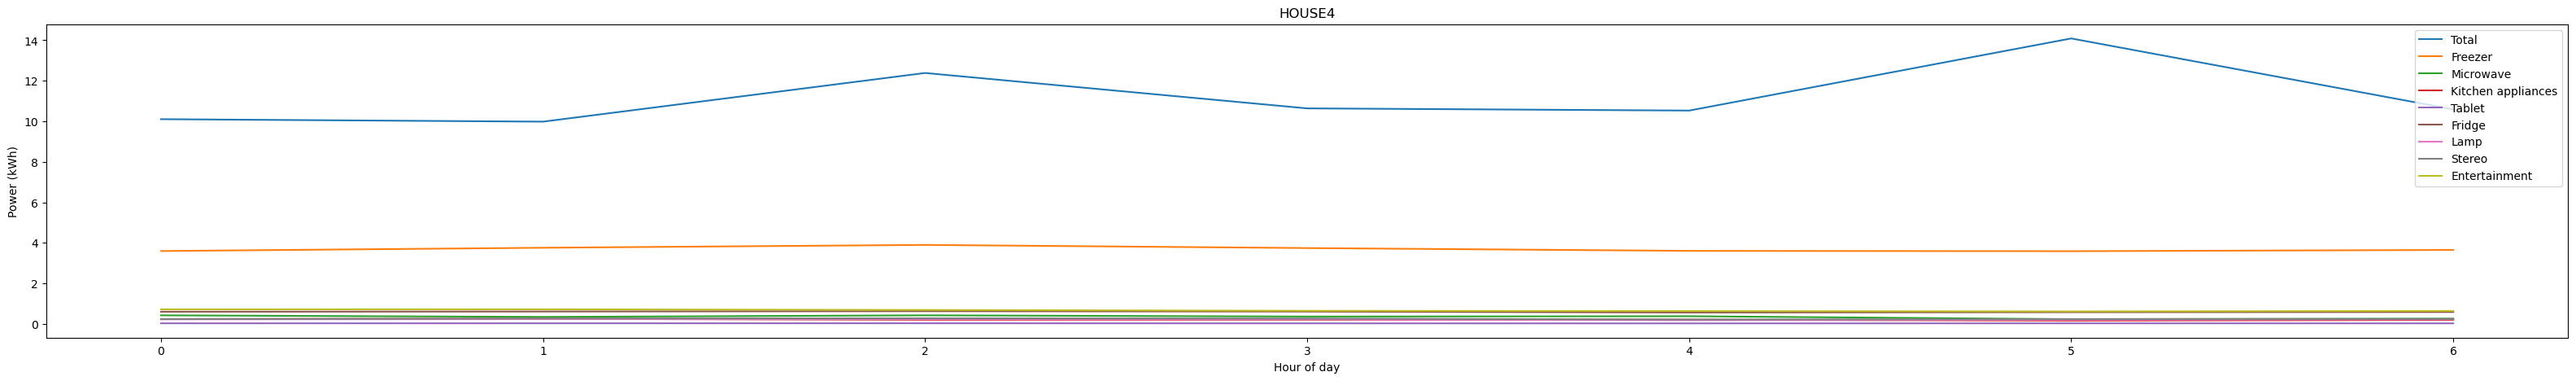

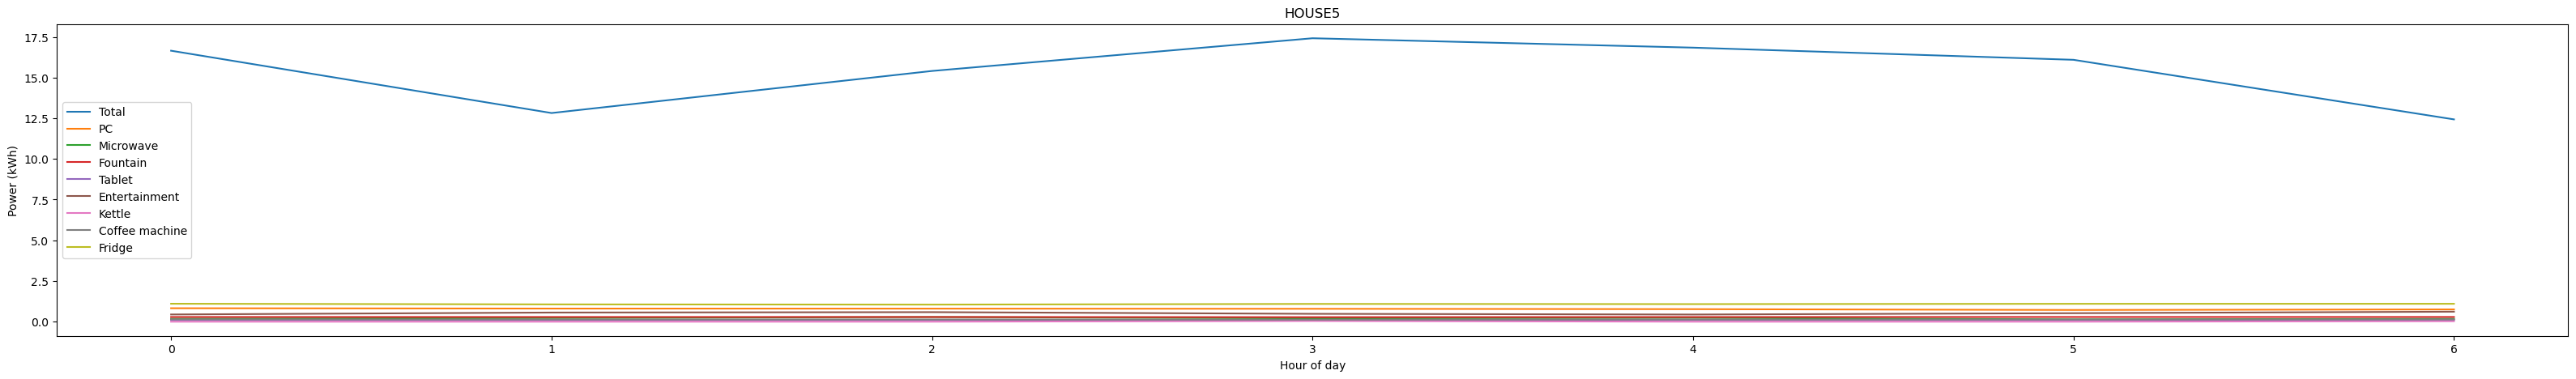

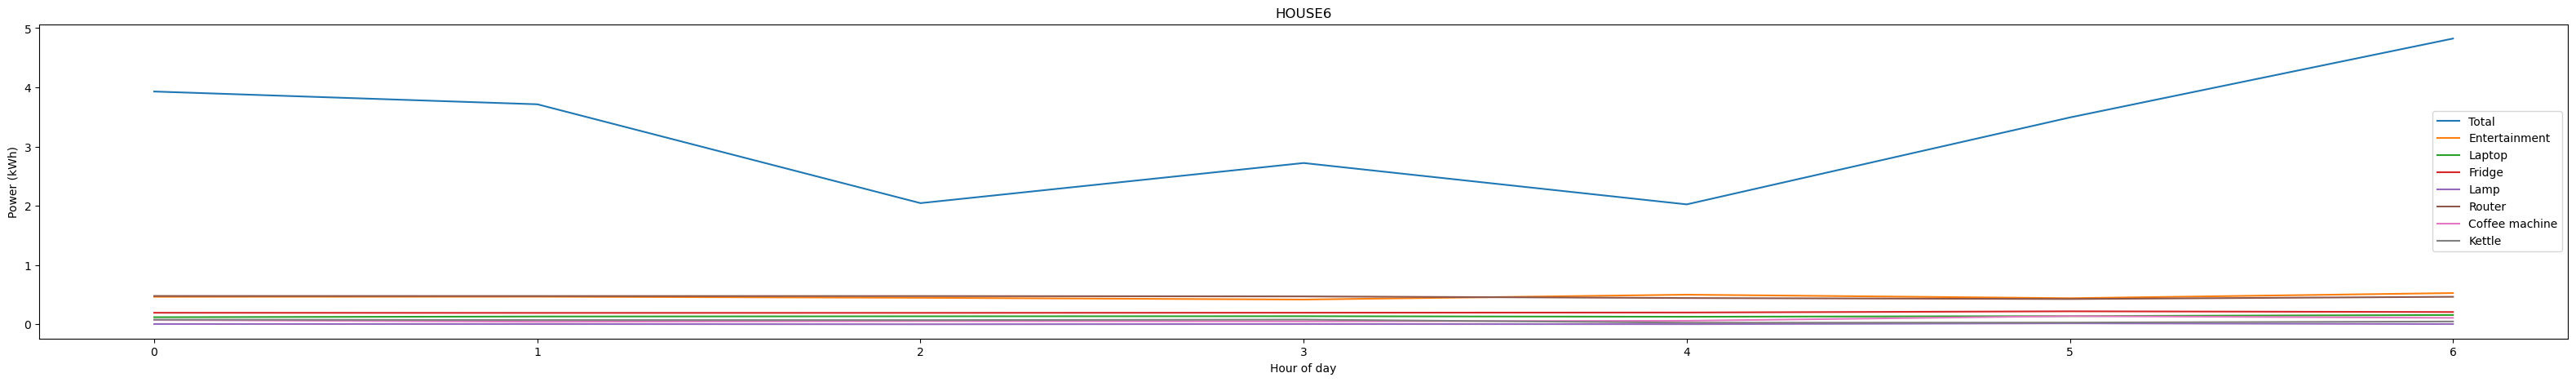

In [29]:
houses= ["HOUSE1", "HOUSE2", "HOUSE3", "HOUSE4", "HOUSE5", "HOUSE6"]
interval = "weekly"
# plot load profiles for each house with legend
for house in houses:
    plt.figure(figsize=(40, 5))
    plt.plot(houses_loadprofiles[house]["total"][interval], label="Total")
    plt.title(house)
    plt.xlabel("Hour of day")
    plt.ylabel("Power (kWh)")
    for device in houses_loadprofiles[house]["devices"]:
        plt.plot(houses_loadprofiles[house]["devices"][device][interval], label=device)
        plt.xlabel("Hour of day")
        plt.ylabel("Power (kWh)")
    plt.legend()

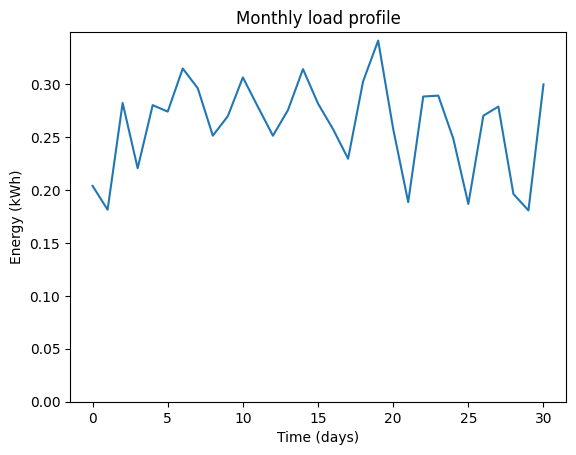

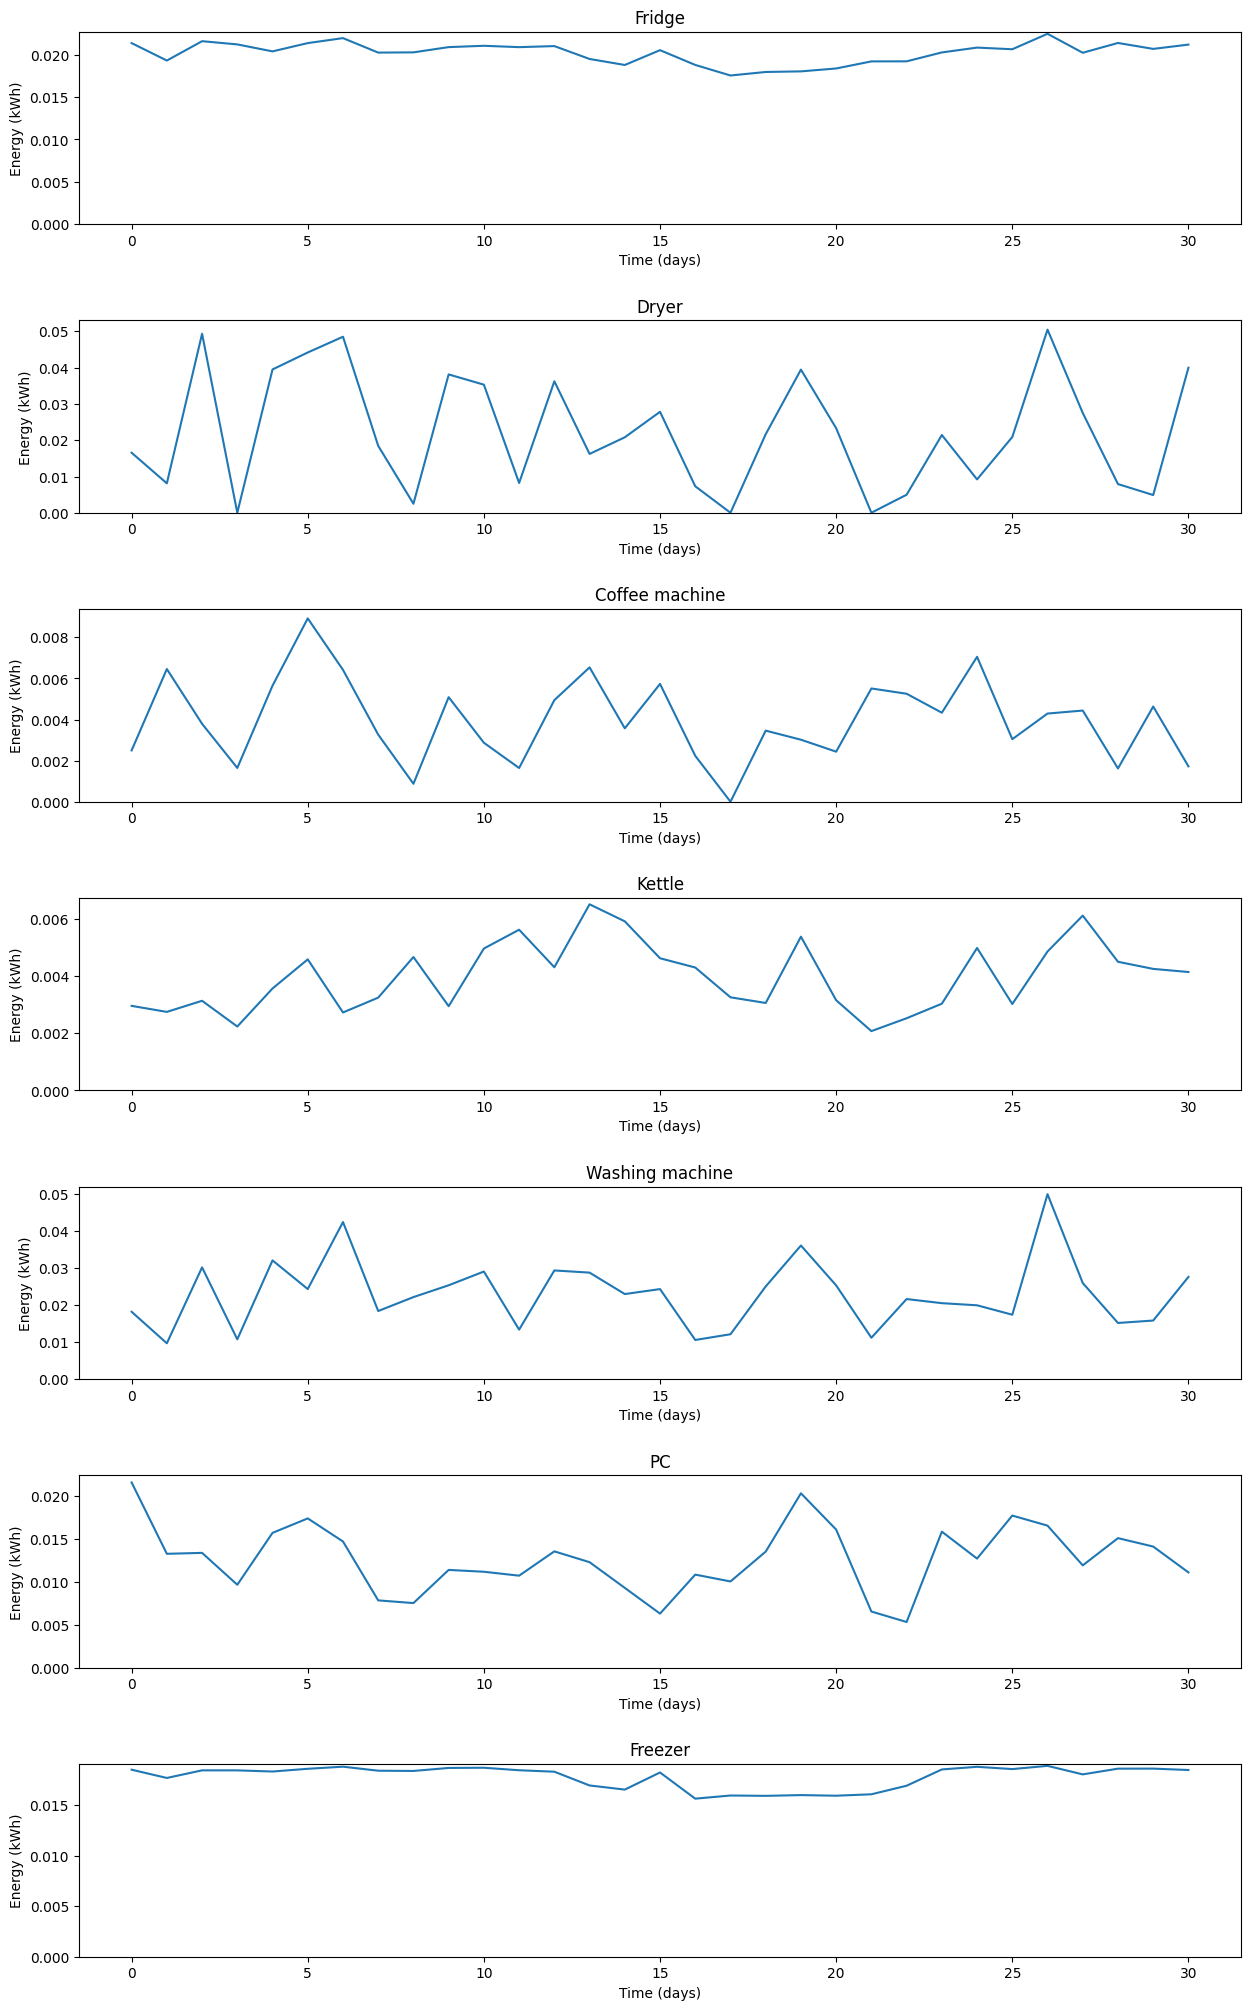

In [145]:
# plot the monthly load profile and make the y axis start from 0.0

fig, ax = plt.subplots()
ax.plot(test_lp["monthly"])

ax.set(xlabel='Time (days)', ylabel='Energy (kWh)',
         title='Monthly load profile')
ax.set_ylim(ymin=0)

# plot the monthly load profiles for all devices so that each device has its own graph
fig, ax = plt.subplots(7,1, figsize=(15,25))
for i, device in enumerate(test_devices):
    ax[i].plot(test_devices[device]["monthly"])
    ax[i].set(xlabel='Time (days)', ylabel='Energy (kWh)',
         title=device)
    ax[i].set_ylim(ymin=0)

plt.subplots_adjust(hspace = 0.5)
plt.show()


In [95]:
df = pd.read_csv(os.path.join(file_path_SM, "2012-06-01.csv"), header=None)
df.drop(df.columns[1:], axis=1, inplace=True)
df.columns = ["Total"]
date_index = pd.date_range(start='2012-06-01', periods=len(df), freq='S')
df.set_index(date_index, inplace=True)

df.head()

,Total
2012-06-01 00:00:00,1020
2012-06-01 00:00:01,1020
2012-06-01 00:00:02,1020
2012-06-01 00:00:03,1020
2012-06-01 00:00:04,1020


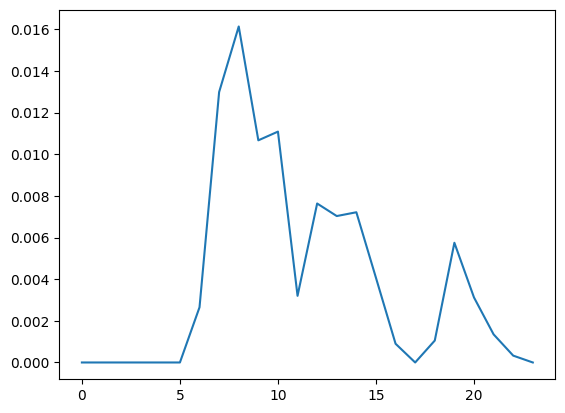

In [88]:
plt.plot(device_lps_fun["Coffee machine"]["daily"])

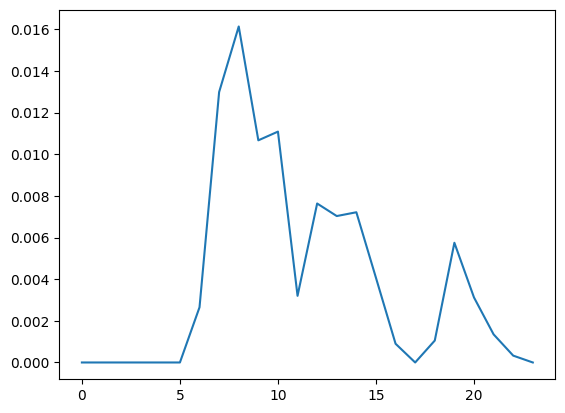

In [81]:

plt.plot(device_lps["Coffee machine"]["daily"])



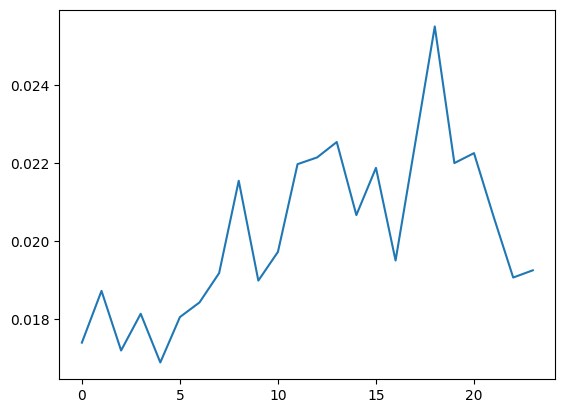

In [17]:
# get data for first day
lp = calculate_loadprofiles(test_df)

plt.plot(lp["daily"])



In [ ]:


# # Initialize an empty list to store device dataframes
# data_dict = {}
# total_consumption = pd.DataFrame()




# # Iterate over each device
# for device in tqdm(device_dict):
    
#     # check if df is empty
#     if len(device_dict[device]) == 0:
#         continue
#     # Concatenate all daily dataframes for the current device
#     device_df = pd.concat(device_dict[device], axis=0)
#     # Sort the index
#     device_df.sort_index(inplace=True)
#     # Reset the index (to handle any potential index related issues)
#     device_df = device_df.reset_index()
#     # Rename the columns to include the device name for uniqueness
#     device_df.columns = ['date', device]

#     # set the date column as the index
#     device_df.set_index('date', inplace=True)
#     print(device_df.head())
#     # Convert the data to kWh
#     device_df = watts2kwh(device_df, data_frequency)

#     if total_consumption.empty:
#         total_consumption = device_df.copy()
#         total_consumption.columns = ["total"]
#         # print(total_consumption.head())
#     else:
#         print(type(device_dict[device]))
#         total_consumption = pd.merge(total_consumption, device_df, on='date', how='inner')
#         total_consumption["total"] = total_consumption["total"] + total_consumption[device]
#         total_consumption.drop(device, axis=1, inplace=True)
#         print(device_df.head())
#         break


  
#     # calculate load profiles and save them in a dictionary
#     data_dict[device] = calculate_loadprofiles(device_df)
    

In [ ]:
data_dict["fridge"]["daily"]

# plot numpy array
plt.plot(data_dict["fridge"]["monthly"])


In [ ]:

total = total_loadprofile(data_dict)
total["daily"]

In [ ]:
# save to pickle

with open('..\..\data\ECO\ECO_loadprofiles.pkl', 'wb') as f:
    pickle.dump(data_dict, f)

    